This is a side project that didn't lead to anything (except the insight of what the integral really is in my data and learning a lot more about python and pandas (especially giving multiple arguments to apply() and lambda functions))

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
from preprocessingFunctions import loadData
from preprocessingFunctions import preProcessChoices
from preprocessingFunctions import preProcessReactionTimes
from preprocessingFunctions import makeSideChoices

from scoringFunctions import scoreChoices
from scoringFunctions import scoreChoicesUnfiltered
from scoringFunctions import scorePerPhase

from analysisFunctions import testRTbasedOnPhaseScoring

from rtDistFunctions import computeDensityPerPhase

from plottingFunctions import plotIt

In [4]:
os.chdir('/home/esther/Desktop/BehavioralTraining')

#%% LOAD IN DATA
Adat,Mdat = loadData()

In [6]:
#%% PREPROCESS DATA (get sides and choices)
choices, sides = preProcessChoices(Adat, Mdat)

In [7]:
# LOAD IN REACTION TIMES AND REMOVE CANCELLED AND TIMED OUT TRIALS
rt_raw = Adat.xs('reaction_time',level = 1, axis = 1)
#rtChoicesFilter = rt_raw[~np.isnan(choices)] # shouldn't need to do this as reaction times are masked by correct and incorrect (Which are already filtered)
rt = rt_raw[rt_raw > 100] # only include trials where researcher did not give reward before sensors were activated 

In [8]:
# determine which trials were correct and incorrect come from sensor scores only
correct, incorrect, nTotalTrials = scoreChoicesUnfiltered(choices, sides)

In [9]:
areaCorrect = rt[correct].stack().groupby(level = ["Phase","Animal"]).apply(np.trapz)

In [10]:
areaIncorrect = rt[incorrect].stack().groupby(level = ["Phase","Animal"]).apply(np.trapz)

In [11]:
integralAvg = pd.concat([areaCorrect.mean(level = "Phase"),areaIncorrect.mean(level = "Phase")], axis = 1, keys =['correct','incorrect'])

In [12]:
integralAvg

,correct,incorrect
Phase,,
1,74594.875,33706.375
2,456597.250,261130.375
3,40185.750,37740.500
4,67806.500,50079.500
5,365448.500,110849.750
6,1025335.125,222449.125
7,918695.500,160115.500


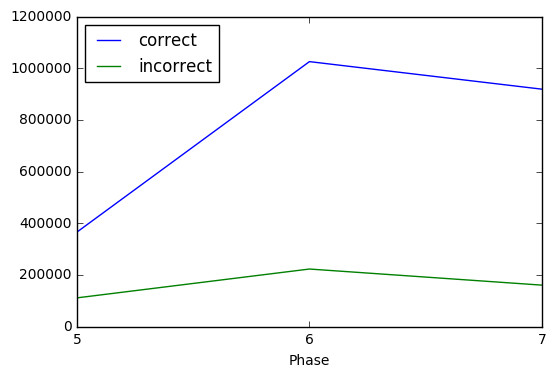

In [13]:
integralAvg.loc[5:7].plot(xticks = [5,6,7])

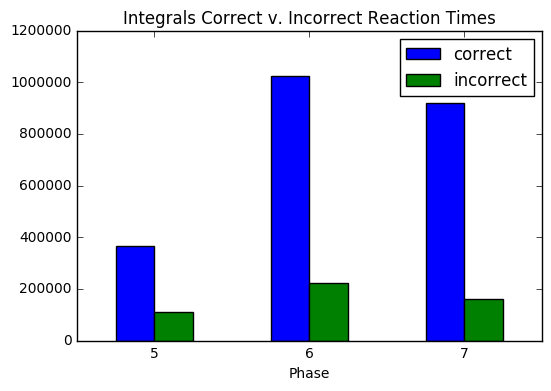

In [14]:
integralAvg.loc[5:7].plot(kind="bar", title = "Integrals Correct v. Incorrect Reaction Times",rot =0)

I'm currently trying to understand what this integration is doing but am not quite there yet. In order to test the trapz function I simulated reaction times in a gaussian distribution and varied the parameters of the dataset to see what effect that had on the calculated integral. 

In [15]:
def testIntegral(mu, sigma, nTrials):
    # create datapoints (reaction times)
    #mu, sigma = 2000, 100 # mean and standard deviation
    s = np.random.normal(mu, sigma, nTrials)

    # plot as histogram and with the probability density function plotted on top in red
    count, bins, ignored = plt.hist(s, 30, normed=True)
    plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
    np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
    linewidth=2, color='r')
    plt.show()
    
    print("Integral: " + str(np.trapz(s)))
    
    binsize =  np.mean(np.diff(bins))
    
    print("Integral Correct For Bin Size: " + str(np.trapz(s)/binsize))


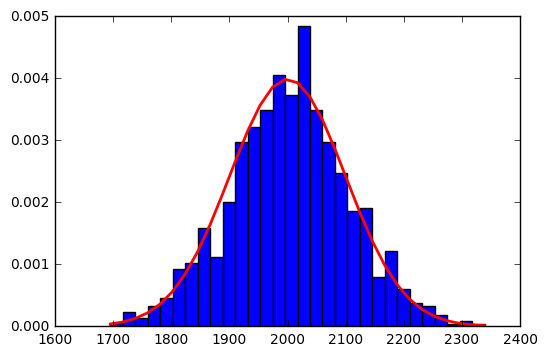

Integral: 2001574.81972
Integral Correct For Bin Size: 93226.1854034


In [17]:
testIntegral(2000,100,1000)

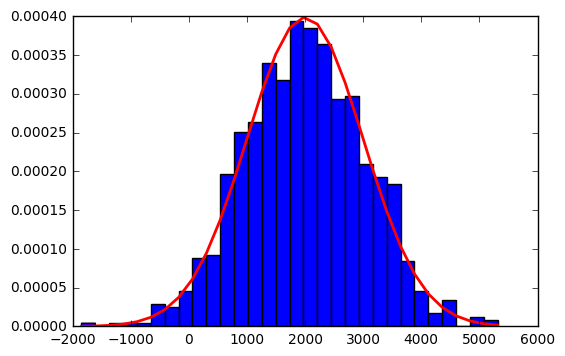

Integral: 1991766.98832
Integral Correct For Bin Size: 8345.48627816


In [18]:
testIntegral(2000,1000,1000)

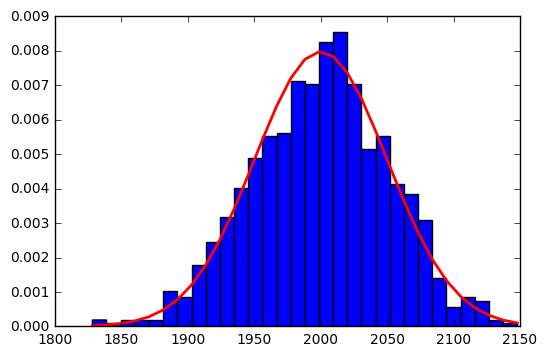

Integral: 1997861.84452
Integral Correct For Bin Size: 187400.951439


In [19]:
testIntegral(2000,50,1000)

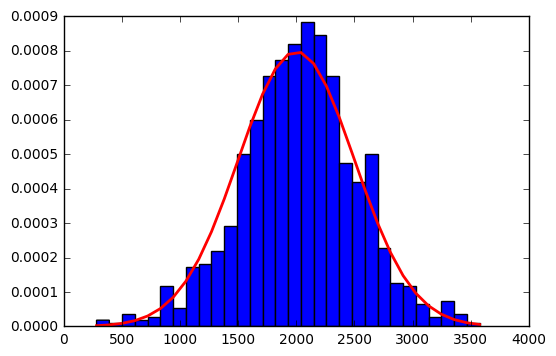

Integral: 2022381.55792
Integral Correct For Bin Size: 18409.6076365


In [16]:
testIntegral(2000,500,1000)

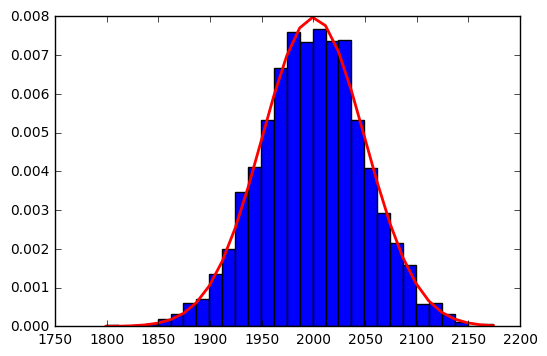

Integral: 5994767.35628
Integral Correct For Bin Size: 479806.718959


In [20]:
testIntegral(2000,50,3000)

10004139.177
1.0


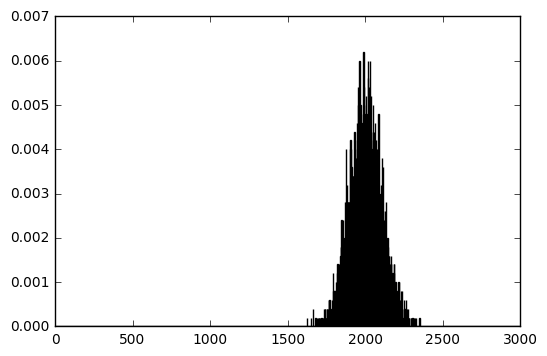

In [21]:
mu, sigma = 2000, 100 # mean and standard deviation
s = np.random.normal(mu, sigma, 5000)

#plt.hist(s, 30, normed=True)
Xbins = range(0,3000)
#count, bins, ignored = plt.hist(s, 30, normed=True)
count, bins, ignored = plt.hist(s, Xbins, normed=True)

print np.trapz(s)
print np.trapz(count,Xbins[:-1])

In [22]:
def computeIntegral(rt, correct, incorrect):
    
    cor = ["Correct","Incorrect"]
    animals = ["1","2","3","4"]
    integralsCorrect = pd.DataFrame(np.nan, columns = animals, index = range(1,8))
    integralsIncorrect = pd.DataFrame(np.nan, columns = animals, index = range(1,8))
    integralsCorrectTest = pd.DataFrame(np.nan, columns = animals, index = range(1,8))
    integralsIncorrectTest = pd.DataFrame(np.nan, columns = animals, index = range(1,8))   
    Xbins = range(0,5000)

    # divide data into groups per phase
    phaseGrouped =rt.groupby(level = "Phase")
    
    for corr in cor:    
    
        if corr == 'Correct':
            sensScoreGrouped = correct.groupby(level = "Phase")
            #c = 0
        else:
            sensScoreGrouped = incorrect.groupby(level = "Phase")
            #c = 1
    
        for p,phase in phaseGrouped:
           
           # select phase
           rtPhase = phaseGrouped.get_group(p)
           sensScorePhase = sensScoreGrouped.get_group(p)
           
           
           for animal in animals:
               
               sel = ~np.isnan(rtPhase[animal]) & sensScorePhase[animal]
               rtAnimal = rtPhase[animal][sel]
               nTrials = len(rtAnimal)
               
               if nTrials < 5: continue
           
               countRtAnimal, bins, ignore = plt.hist(rtAnimal, Xbins, histtype='step')
               
               integral = np.trapz(countRtAnimal, Xbins[:-1])
               integralTest = np.trapz(countRtAnimal, Xbins[:-1])/nTrials

               if corr == 'Correct':
                   integralsCorrect.iloc[p-1,int(animal)-1] = integral
                   integralsCorrectTest.iloc[p-1,int(animal)-1] = integralTest
               else:
                   integralsIncorrect.iloc[p-1,int(animal)-1] = integral
                   integralsIncorrectTest.iloc[p-1,int(animal)-1] = integralTest
                                        
          
    integrals = pd.concat([integralsCorrect,integralsIncorrect], axis = 1, keys =['correct','incorrect'])
    integralsTest = pd.concat([integralsCorrectTest,integralsIncorrectTest], axis = 1, keys =['correct','incorrect'])

    return integrals, integralsTest

In [ ]:
integrals, integralsTest = computeIntegral(rt, correct, incorrect)

Right, so dividing by nTrials normalizes the results...so the integral actually resembles the amount of trials...I suppose that makes sense (slapping hand against face right now)

In [ ]:
integralAvg = pd.concat([integrals.correct.mean(axis=1),integrals.incorrect.mean(axis=1)], axis = 1, keys =['correct','incorrect'])

In [ ]:
integralAvg.plot(kind="bar", title = "Integrals Correct v. Incorrect Reaction Times",rot =0)

In [ ]:
Xbins = range(0,5000)
XbinsForTrapz = range(0,4999)
#XbinsForTrapz = Xbins[:-1]
args = (Xbins,)
kwargsHist = {"histtype": "step"}
kwargsTrapz = {"x": XbinsForTrapz}

In [ ]:
# this doesn't work, I wanted to see if I could do it within one sentence, but that's not the holy grail I suppose (its proved to be too difficult to get it to output the bin counts using hist, or at least pass only the bin counts to the following apply function (np.trapz). I have figured out how to give mutiple arguments to apply now though)
rtCorrectInts = rt[correct].stack().groupby(level = ["Phase","Animal"]).agg([(plt.hist,*args, **kwargsHist),(np.trapz, **{"x": Xbins}])

In [ ]:
# this is unnecessarily complicated, I suppose I really should give up now..
rtCorrectInts = rt[correct].stack().groupby(level = ["Phase","Animal"]).apply(np.trapz(lambda h: plt.hist(h, Xbins, "histtype": "step"), x = Xbins[:-1]))